In [1]:
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, explained_variance_score

# Models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier



import warnings
warnings.filterwarnings("ignore")

In [2]:
cv_n_split = 5
random_state = 42
test_train_split_part = 0.25

In [3]:
metrics_all = {1: 'acc', 2 : 'rmse', 3 : 're'}
metrics_now = [1, 2, 3] # you can only select some numbers of metrics from metrics_all

In [4]:
data = pd.read_csv("/Sumanka/Documents/DS/heart_disease.csv")
data['target'] = data['num']
data = data.drop(columns=['id', 'dataset', 'ca', 'thal', 'num'])

In [5]:
data.head(3)

age   sex              cp  trestbps   chol    fbs         restecg  thalch  \
0   63  Male  typical angina     145.0  233.0   True  lv hypertrophy   150.0   
1   67  Male    asymptomatic     160.0  286.0  False  lv hypertrophy   108.0   
2   67  Male    asymptomatic     120.0  229.0  False  lv hypertrophy   129.0   

   exang  oldpeak        slope  target  
0  False      2.3  downsloping       0  
1   True      1.5         flat       2  
2   True      2.6         flat       1

In [6]:
data = data[(data['chol'] <= 420) & (data['oldpeak'] >=0) & (data['oldpeak'] <=4)].reset_index(drop=True)
data = data.dropna().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       520 non-null    int64  
 1   sex       520 non-null    object 
 2   cp        520 non-null    object 
 3   trestbps  520 non-null    float64
 4   chol      520 non-null    float64
 5   fbs       520 non-null    object 
 6   restecg   520 non-null    object 
 7   thalch    520 non-null    float64
 8   exang     520 non-null    object 
 9   oldpeak   520 non-null    float64
 10  slope     520 non-null    object 
 11  target    520 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 48.9+ KB


In [7]:
data.describe()

age    trestbps        chol      thalch     oldpeak      target
count  520.000000  520.000000  520.000000  520.000000  520.000000  520.000000
mean    54.780769  133.365385  215.436538  138.744231    1.183269    1.121154
std      8.873442   18.971664   95.672469   25.792375    1.031624    1.175675
min     29.000000    0.000000    0.000000   60.000000    0.000000    0.000000
25%     48.750000  120.000000  197.000000  120.000000    0.100000    0.000000
50%     56.000000  130.000000  233.000000  140.000000    1.000000    1.000000
75%     61.000000  142.000000  271.250000  159.000000    2.000000    2.000000
max     77.000000  200.000000  417.000000  202.000000    4.000000    4.000000

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       520 non-null    int64  
 1   sex       520 non-null    object 
 2   cp        520 non-null    object 
 3   trestbps  520 non-null    float64
 4   chol      520 non-null    float64
 5   fbs       520 non-null    object 
 6   restecg   520 non-null    object 
 7   thalch    520 non-null    float64
 8   exang     520 non-null    object 
 9   oldpeak   520 non-null    float64
 10  slope     520 non-null    object 
 11  target    520 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 48.9+ KB


In [9]:
def str_features_to_numeric(data):
  
    categorical_columns = []
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    features = data.columns.values.tolist()
    for col in features:
        if data[col].dtype in numerics: continue
        categorical_columns.append(col)
    
    # Encoding categorical features
    for col in categorical_columns:
        if col in data.columns:
            le = LabelEncoder()
            le.fit(list(data[col].astype(str).values))
            data[col] = le.transform(list(data[col].astype(str).values))
    
    return data

In [10]:
# Transform all string features of the df to numeric features
data = str_features_to_numeric(data)
data

age  sex  cp  trestbps   chol  fbs  restecg  thalch  exang  oldpeak  \
0     63    1   3     145.0  233.0    1        0   150.0      0      2.3   
1     67    1   0     160.0  286.0    0        0   108.0      1      1.5   
2     67    1   0     120.0  229.0    0        0   129.0      1      2.6   
3     37    1   2     130.0  250.0    0        1   187.0      0      3.5   
4     41    0   1     130.0  204.0    0        0   172.0      0      1.4   
..   ...  ...  ..       ...    ...  ...      ...     ...    ...      ...   
515   57    1   0     130.0  207.0    0        2    96.0      1      1.0   
516   74    1   0     155.0  310.0    0        1   112.0      1      1.5   
517   51    0   0     114.0  258.0    1        0    96.0      0      1.0   
518   62    1   0     160.0  254.0    1        2   108.0      1      3.0   
519   53    1   0     144.0  300.0    1        2   128.0      1      1.5   

     slope  target  
0        0       0  
1        1       2  
2        1       1  
3        0       0  
4        2       0  
..     ...     ...  
515      1       0  
516      0       2  
517      2       0  
518      1       4  
519      1       3  

[520 rows x 12 columns]

In [11]:
data.target.value_counts()

0    203
1    159
2     70
3     68
4     20
Name: target, dtype: int64

In [12]:
# target = 0 or 1 ==> more data
data = data[data['target'].isin([0, 1])]
data

age  sex  cp  trestbps   chol  fbs  restecg  thalch  exang  oldpeak  \
0     63    1   3     145.0  233.0    1        0   150.0      0      2.3   
2     67    1   0     120.0  229.0    0        0   129.0      1      2.6   
3     37    1   2     130.0  250.0    0        1   187.0      0      3.5   
4     41    0   1     130.0  204.0    0        0   172.0      0      1.4   
5     56    1   1     120.0  236.0    0        1   178.0      0      0.8   
..   ...  ...  ..       ...    ...  ...      ...     ...    ...      ...   
512   60    1   0     130.0  186.0    1        0   140.0      1      0.5   
513   55    1   0     120.0  226.0    0        0   127.0      1      1.7   
514   56    1   0     130.0  203.0    1        1    98.0      0      1.5   
515   57    1   0     130.0  207.0    0        2    96.0      1      1.0   
517   51    0   0     114.0  258.0    1        0    96.0      0      1.0   

     slope  target  
0        0       0  
2        1       1  
3        0       0  
4        2       0  
5        2       0  
..     ...     ...  
512      1       1  
513      0       1  
514      1       1  
515      1       0  
517      2       0  

[362 rows x 12 columns]

In [13]:
def fe_creation(df):
    df['age2'] = df['age']//10
    df['trestbps2'] = df['trestbps']//10
    df['chol2'] = df['chol']//60
    df['thalch2'] = df['thalch']//40
    df['oldpeak2'] = df['oldpeak']//0.4
    for i in ['sex', 'age2', 'fbs', 'restecg', 'exang']:
        for j in ['cp','trestbps2', 'chol2', 'thalch2', 'oldpeak2', 'slope']:
            df[i + "_" + j] = df[i].astype('str') + "_" + df[j].astype('str')
    return df

data = fe_creation(data)

In [14]:
# Transform all string features of the df to numeric features
pd.set_option('max_columns', len(data.columns)+1)
data = str_features_to_numeric(data)
data.head(3)

age  sex  cp  trestbps   chol  fbs  restecg  thalch  exang  oldpeak  slope  \
0   63    1   3     145.0  233.0    1        0   150.0      0      2.3      0   
2   67    1   0     120.0  229.0    0        0   129.0      1      2.6      1   
3   37    1   2     130.0  250.0    0        1   187.0      0      3.5      0   

   target  age2  trestbps2  chol2  thalch2  oldpeak2  sex_cp  sex_trestbps2  \
0       0     6       14.0    3.0      3.0       5.0       7             14   
2       1     6       12.0    3.0      3.0       6.0       4             12   
3       0     3       13.0    4.0      4.0       8.0       6             13   

   sex_chol2  sex_thalch2  sex_oldpeak2  sex_slope  age2_cp  age2_trestbps2  \
0          9            4            11          3       16              30   
2          9            4            12          4       13              28   
3         10            5            14          3        3               4   

   age2_chol2  age2_thalch2  age2_oldpeak2  age2_slope  fbs_cp  fbs_trestbps2  \
0          22            11             30          10       7             16   
2          22            11             31          11       0              2   
3           5             3              8           1       2              3   

   fbs_chol2  fbs_thalch2  fbs_oldpeak2  fbs_slope  restecg_cp  \
0          9            5            15          3           3   
2          3            1             6          1           0   
3          4            2             8          0           6   

   restecg_trestbps2  restecg_chol2  restecg_thalch2  restecg_oldpeak2  \
0                  4              2                1                 5   
2                  2              2                1                 6   
3                 12             10                6                15   

   restecg_slope  exang_cp  exang_trestbps2  exang_chol2  exang_thalch2  \
0              0         3                4            2              1   
2              1         4               12            9              5   
3              3         2                3            3              2   

   exang_oldpeak2  exang_slope  
0               5            0  
2              15            4  
3               8            0

In [16]:
data.shape

(362, 47)

In [17]:
features_best = data.columns.tolist()
pd.set_option('max_columns', len(features_best)+1)

In [19]:
data.describe()

age         sex          cp    trestbps        chol         fbs  \
count  362.000000  362.000000  362.000000  362.000000  362.000000  362.000000   
mean    53.049724    0.698895    0.895028  132.085635  230.179558    0.132597   
std      8.803976    0.459373    1.001399   17.740539   78.592559    0.339608   
min     29.000000    0.000000    0.000000   92.000000    0.000000    0.000000   
25%     47.000000    0.000000    0.000000  120.000000  204.000000    0.000000   
50%     54.000000    1.000000    1.000000  130.000000  235.500000    0.000000   
75%     59.000000    1.000000    2.000000  140.000000  273.000000    0.000000   
max     76.000000    1.000000    3.000000  200.000000  417.000000    1.000000   

          restecg      thalch       exang     oldpeak       slope      target  \
count  362.000000  362.000000  362.000000  362.000000  362.000000  362.000000   
mean     0.812155  143.469613    0.419890    0.984254    1.356354    0.439227   
std      0.598304   25.301187    0.494224    0.898136    0.574216    0.496980   
min      0.000000   82.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  124.000000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  147.000000    0.000000    1.000000    1.000000    0.000000   
75%      1.000000  162.000000    1.000000    1.500000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    4.000000    2.000000    1.000000   

             age2   trestbps2       chol2     thalch2    oldpeak2      sex_cp  \
count  362.000000  362.000000  362.000000  362.000000  362.000000  362.000000   
mean     4.850829   13.016575    3.381215    3.140884    2.058011    3.690608   
std      0.917580    1.835251    1.247038    0.693889    2.005382    1.998163   
min      2.000000    9.000000    0.000000    2.000000    0.000000    0.000000   
25%      4.000000   12.000000    3.000000    3.000000    0.000000    2.000000   
50%      5.000000   13.000000    3.000000    3.000000    2.000000    4.000000   
75%      5.000000   14.000000    4.000000    4.000000    3.000000    5.000000   
max      7.000000   20.000000    6.000000    5.000000    9.000000    7.000000   

       sex_trestbps2   sex_chol2  sex_thalch2  sex_oldpeak2   sex_slope  \
count     362.000000  362.000000   362.000000    362.000000  362.000000   
mean       10.132597    7.279006     3.237569      6.248619    3.453039   
std         5.054724    3.206132     1.478909      3.745218    1.423683   
min         0.000000    0.000000     0.000000      0.000000    0.000000   
25%         5.000000    4.000000     2.000000      3.000000    2.000000   
50%        12.000000    9.000000     4.000000      6.000000    4.000000   
75%        14.000000   10.000000     4.000000      9.000000    5.000000   
max        21.000000   12.000000     6.000000     15.000000    5.000000   

          age2_cp  age2_trestbps2  age2_chol2  age2_thalch2  age2_oldpeak2  \
count  362.000000      362.000000  362.000000    362.000000     362.000000   
mean     9.303867       17.342541   15.262431      7.690608      17.397790   
std      3.787490        8.655539    5.932228      2.660550       7.583829   
min      0.000000        0.000000    0.000000      0.000000       0.000000   
25%      6.000000       10.000000   10.000000      6.000000      11.250000   
50%      9.000000       17.000000   16.000000      8.000000      17.000000   
75%     12.000000       21.000000   18.000000      9.000000      22.000000   
max     19.000000       41.000000   30.000000     15.000000      37.000000   

       age2_slope      fbs_cp  fbs_trestbps2   fbs_chol2  fbs_thalch2  \
count  362.000000  362.000000     362.000000  362.000000   362.000000   
mean     7.908840    1.425414       4.740331    4.185083     1.671271   
std      2.803832    1.777426       4.612278    2.408779     1.512534   
min      0.000000    0.000000       0.000000    0.000000     0.000000   
25%      6.000000    0.000000       2.000000    3.000000     1.000000   
50%    

In [20]:
# Target
dataset = data.copy()  # original data
target_name = 'target'
target = data.pop(target_name)

In [21]:
# Model standartization
scaler = StandardScaler()
#scaler = RobustScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

In [22]:
# Synthesis valid as test for selection models
train, valid, train_target, valid_target = train_test_split(data, target, test_size=test_train_split_part, random_state=random_state)

In [23]:
train

age       sex        cp  trestbps      chol       fbs   restecg  \
60  -0.915594  0.656376 -0.895014 -1.585324 -0.282600 -0.390981 -1.359306   
195  0.904282  0.656376 -0.895014  0.446735 -0.295341 -0.390981 -1.359306   
302 -0.688109  0.656376 -0.895014  1.575657  0.774941 -0.390981  1.988101   
132 -0.005656  0.656376  1.104956 -0.117726  0.201576  2.557668 -1.359306   
220 -1.029336  0.656376  0.104971 -0.682187 -0.588395 -0.390981  0.314397   
..        ...       ...       ...       ...       ...       ...       ...   
71  -1.029336 -1.523516  1.104956 -1.359540 -1.136278 -0.390981  0.314397   
106 -0.688109  0.656376  1.104956 -1.359540  0.163351 -0.390981  0.314397   
270 -0.346882  0.656376 -0.895014 -0.117726  0.035937 -0.390981  0.314397   
348  0.108087 -1.523516 -0.895014  0.333843  0.558336 -0.390981  0.314397   
102  0.676798  0.656376  2.104940  2.140118  0.736717 -0.390981 -1.359306   

       thalch     exang   oldpeak     slope      age2  trestbps2    chol2  \
60   0.179306  1.175406  2.247471 -0.621450 -0.928537  -1.645960 -0.30612   
195 -0.216479  1.175406  1.021018  1.122465  1.254128   0.536595 -0.30612   
302  0.575092  1.175406  2.247471 -0.621450 -0.928537   1.627873  0.49689   
132  1.168770 -0.850770 -1.097402  1.122465  0.162795  -0.009044  0.49689   
220 -0.058165 -0.850770  0.017556 -0.621450 -0.928537  -0.554683 -0.30612   
..        ...       ...       ...       ...       ...        ...      ...   
71   1.247927 -0.850770 -0.428427 -0.621450 -0.928537  -1.645960 -1.10913   
106  0.337620 -0.850770 -1.097402  1.122465 -0.928537  -1.645960  0.49689   
270 -0.889315  1.175406  1.132514 -0.621450  0.162795  -0.009044 -0.30612   
348 -1.522571  1.175406  0.575035 -0.621450  0.162795  -0.009044  0.49689   
102  0.614670 -0.850770 -0.874410 -0.621450  0.162795   2.173512  0.49689   

      thalch2  oldpeak2    sex_cp  sex_trestbps2  sex_chol2  sex_thalch2  \
60  -0.203316  2.467774  0.155053      -0.026269   0.537525      0.51625   
195 -0.203316  0.969729  0.155053       0.766166   0.537525      0.51625   
302 -0.203316  2.467774  0.155053       1.162383   0.849859      0.51625   
132  1.239831 -1.027664  1.157358       0.568057   0.849859      1.19336   
220 -0.203316 -0.028968  0.656205       0.369949   0.537525      0.51625   
..        ...       ...       ...            ...        ...          ...   
71   1.239831 -0.528316 -0.847252      -2.007354  -1.961147     -0.83797   
106 -0.203316 -1.027664  1.157358      -0.026269   0.849859      0.51625   
270 -0.203316  0.969729  0.155053       0.568057   0.537525      0.51625   
348 -1.646464  0.470381 -1.849557      -1.413028  -1.336479     -2.19219   
102 -0.203316 -1.027664  1.658510       1.360491   0.849859      0.51625   

     sex_oldpeak2  sex_slope   age2_cp  age2_trestbps2  age2_chol2  \
60       1.805162   0.384719 -1.137910       -1.196558   -1.057124   
195      1.003032   1.088095  0.977230        1.464378    1.137329   
302      1.805162   0.384719 -1.137910       -0.502401   -0.888320   
132     -0.066475   1.088095  0.448445       -0.039630    0.293309   
220      0.468279   0.384719 -0.873518       -0.965173   -1.057124   
..            ...        ...       ...             ...         ...   
71      -1.403358  -1.725407 -0.609125       -1.196558   -1.225928   
106     -0.066475   1.088095 -0.609125       -1.196558   -0.888320   
270      1.003032   0.384719 -0.080340       -0.039630    0.124505   
348     -0.868605  -1.725407 -0.080340       -0.039630    0.293309   
102     -0.066475   0.384719  0.712837        0.423142    0.293309   

     age2_thalch2  age2_oldpeak2  age2_slope    fbs_cp  fbs_trestbps2  \
60      -1.012697      -0.448651   -1.038888 -0.803064      -1.029186   
195      1.245597       1.531979    1.461151 -0.803064      -0.160735   
302     -1.012697      -0.448651   -1.038888 -0.803064       0.273490   
132      0.492832      -0.184567    0.389706  2.577277       2.227504   
220     -1.012697      -0.844777   -1.038

In [24]:
valid

age       sex        cp  trestbps      chol       fbs   restecg  \
163  1.131767 -1.523516 -0.895014 -1.359540  0.494629 -0.390981  0.314397   
33   0.904282 -1.523516 -0.895014 -0.117726  1.271858 -0.390981 -1.359306   
15  -0.460625  0.656376  0.104971 -0.117726  0.456405 -0.390981  0.314397   
322  2.269190 -1.523516  1.104956  1.575657 -2.932824 -0.390981  1.988101   
57   0.790540  0.656376 -0.895014 -0.399956  0.354473 -0.390981 -1.359306   
..        ...       ...       ...       ...       ...       ...       ...   
316  0.676798  0.656376 -0.895014  0.164504 -2.932824 -0.390981  0.314397   
310 -1.711790 -1.523516 -0.895014 -1.246648 -2.932824 -0.390981  0.314397   
339  0.563056  0.656376 -0.895014 -0.682187 -2.932824 -0.390981 -1.359306   
110 -0.119398  0.656376  2.104940  1.124088  0.864132  2.557668  0.314397   
295  0.335571  0.656376 -0.895014  1.011196 -0.002288 -0.390981  1.988101   

       thalch     exang   oldpeak     slope      age2  trestbps2     chol2  \
163  1.010455  1.175406  0.909522 -0.621450  1.254128  -1.645960  0.496890   
33   1.010455 -0.850770 -1.097402  1.122465  1.254128  -0.009044  1.299901   
15   1.089613 -0.850770 -0.428427  1.122465 -0.928537  -0.009044  0.496890   
322 -0.889315 -0.850770 -1.097402  1.122465  2.345460   1.627873 -2.715151   
57  -0.097744  1.175406  2.024480 -0.621450  1.254128  -0.554683  0.496890   
..        ...       ...       ...       ...       ...        ...       ...   
316 -1.126786  1.175406  0.017556 -0.621450  0.162795  -0.009044 -2.715151   
310  0.495934 -0.850770 -1.097402 -0.621450 -2.019869  -1.100321 -2.715151   
339 -1.482993  1.175406  0.575035 -2.365366  0.162795  -0.554683 -2.715151   
110  1.366662 -0.850770  0.240548 -0.621450  0.162795   1.082234  0.496890   
295 -0.770579  1.175406  0.575035 -0.621450  0.162795   1.082234 -0.306120   

      thalch2  oldpeak2    sex_cp  sex_trestbps2  sex_chol2  sex_thalch2  \
163  1.239831  0.969729 -1.849557      -2.007354  -1.336479     -0.83797   
33   1.239831 -1.027664 -1.849557      -1.413028  -1.024145     -0.83797   
15   1.239831 -0.528316  0.656205       0.568057   0.849859      1.19336   
322 -0.203316 -1.027664 -0.847252      -0.818703  -2.273481     -1.51508   
57  -0.203316  1.968426  0.155053       0.369949   0.849859      0.51625   
..        ...       ...       ...            ...        ...          ...   
316 -1.646464 -0.028968  0.155053       0.568057  -0.399477     -0.16086   
310 -0.203316 -1.027664 -1.849557      -1.809246  -2.273481     -1.51508   
339 -1.646464  0.470381  0.155053       0.369949  -0.399477     -0.16086   
110  1.239831 -0.028968  1.658510       0.964274   0.849859      1.19336   
295 -0.203316  0.470381  0.155053       0.964274   0.537525      0.51625   

     sex_oldpeak2  sex_slope   age2_cp  age2_trestbps2  age2_chol2  \
163     -0.601228  -1.725407  0.977230        1.001606    1.306133   
33      -1.670735  -1.022032  0.977230        1.348685    1.474937   
15       0.200902   1.088095 -0.873518       -0.849480   -0.888320   
322     -1.670735  -1.022032  2.563585        2.736999    1.812545   
57       1.537785   0.384719  0.977230        1.232992    1.306133   
..            ...        ...       ...             ...         ...   
316      0.468279   0.384719 -0.080340       -0.039630   -0.381908   
310     -1.670735  -1.725407 -2.195480       -1.775023   -2.407556   
339      0.735655  -0.318656 -0.080340       -0.155322   -0.381908   
110      0.468279   0.384719  0.712837        0.191756    0.293309   
295      0.735655   0.384719 -0.080340        0.191756    0.124505   

     age2_thalch2  age2_oldpeak2  age2_slope    fbs_cp  fbs_trestbps2  \
163      1.621979       1.531979    1.104003 -0.803064      -1.029186   
33       1.621979       1.003811    1.461151 -0.803064      -0.377848   
15      -0.636315      -0.976819   -0.681739 -0.239674      -0.377848   
322      2.374744       2.060147    2.532597  0.323716       0.273490   
57       1.245597       1.796

In [25]:
# list of accuracy of all model - amount of metrics_now * 2 (train & valid datasets)
num_models = 6
acc_train = []
acc_valid = []
acc_all = np.empty((len(metrics_now)*2, 0)).tolist()
acc_all

[[], [], [], [], [], []]

In [26]:
acc_all_pred = np.empty((len(metrics_now), 0)).tolist()
acc_all_pred

[[], [], []]

In [27]:
# Splitting train data for model tuning with cross-validation
cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_train_split_part, random_state=random_state)

In [28]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [29]:
def plot_cm(train_target, train_target_pred, valid_target, valid_target_pred):    
    # Building the confusion matrices
    
    def cm_calc(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)
        cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
        cm.index.name = 'Actual'
        cm.columns.name = 'Predicted'
        return cm, annot

    
    # Building the confusion matrices
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharex=True)
    
    # Training data
    ax = axes[0]
    ax.set_title("for training data")
    cm0, annot0 = cm_calc(train_target, train_target_pred)    
    sns.heatmap(cm0, cmap= "YlGnBu", annot=annot0, fmt='', ax=ax)
    
    # Test data
    ax = axes[1]
    ax.set_title("for test (validation) data")
    cm1, annot1 = cm_calc(valid_target, valid_target_pred)
    sns.heatmap(cm1, cmap= "YlGnBu", annot=annot1, fmt='', ax=ax)
    
    fig.suptitle('CONFUSION MATRICES')
    plt.show()

In [30]:
def acc_metrics_calc(num, acc_all, model, train, valid, train_target, valid_target):
    # The models selection stage
    # Calculation of accuracy of model by different metrics
    
    ytrain = model.predict(train).astype(int)
    yvalid = model.predict(valid).astype(int)
    print('train_target = ', train_target[:5].values)
    print('ytrain = ', ytrain[:5])
    print('valid_target =', valid_target[:5].values)
    print('yvalid =', yvalid[:5])

    num_acc = 0
    for x in metrics_now:
        if x == 1:
            #accuracy_score criterion
            acc_train = round(metrics.accuracy_score(train_target, ytrain), 2)
            acc_valid = round(metrics.accuracy_score(valid_target, yvalid), 2)
        elif x == 2:
            #rmse criterion
            acc_train = round(acc_rmse(train_target, ytrain), 2)
            acc_valid = round(acc_rmse(valid_target, yvalid), 2)
        elif x == 3:
            #relative error criterion
            acc_train = round(acc_d(train_target, ytrain) * 100, 2)
            acc_valid = round(acc_d(valid_target, yvalid) * 100, 2)
        
        print('acc of', metrics_all[x], 'for train =', acc_train)
        print('acc of', metrics_all[x], 'for valid =', acc_valid)
        acc_all[num_acc].append(acc_train) #train
        acc_all[num_acc+1].append(acc_valid) #valid
        num_acc += 2
    
    #  Building the confusion matrices
    plot_cm(train_target, ytrain, valid_target, yvalid)
    
    return acc_all

In [31]:
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_train_split_part, random_state=random_state)
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator=estimator, X=X, y=y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    plt.show()
    return

### 5.1 Decision Tree Classifier<a class="anchor" id="5.1"></a>

[Back to Table of Contents](#0.1)

This model uses a **Decision Tree** as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning).

{'min_samples_leaf': 11}
train_target =  [0 1 1 0 0]
ytrain =  [0 1 0 0 0]
valid_target = [1 1 0 1 1]
yvalid = [0 0 0 0 1]
acc of acc for train = 0.82
acc of acc for valid = 0.7
acc of rmse for train = 0.43
acc of rmse for valid = 0.54
acc of re for train = 41.53
acc of re for valid = 65.85


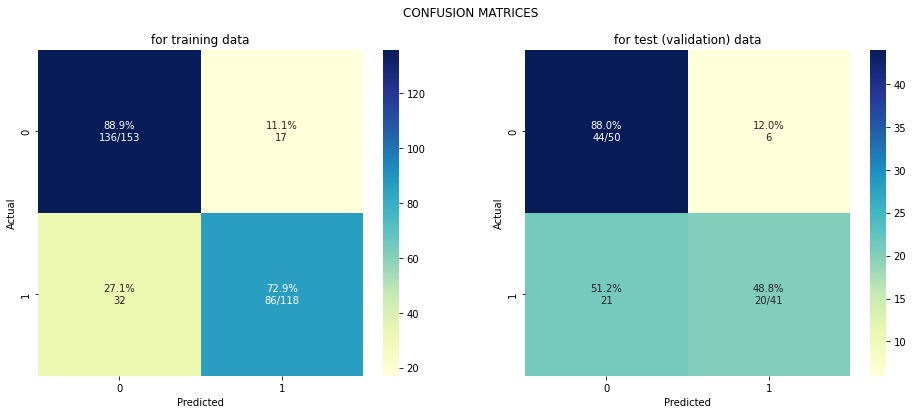

In [32]:
# Decision Tree Classifier
decision_tree = DecisionTreeClassifier()
param_grid = {'min_samples_leaf': [i for i in range(2,12)]}
decision_tree_CV = GridSearchCV(decision_tree, param_grid=param_grid, cv=cv_train, verbose=False)
decision_tree_CV.fit(train, train_target)
print(decision_tree_CV.best_params_)
acc_all = acc_metrics_calc(0, acc_all, decision_tree_CV, train, valid, train_target, valid_target)

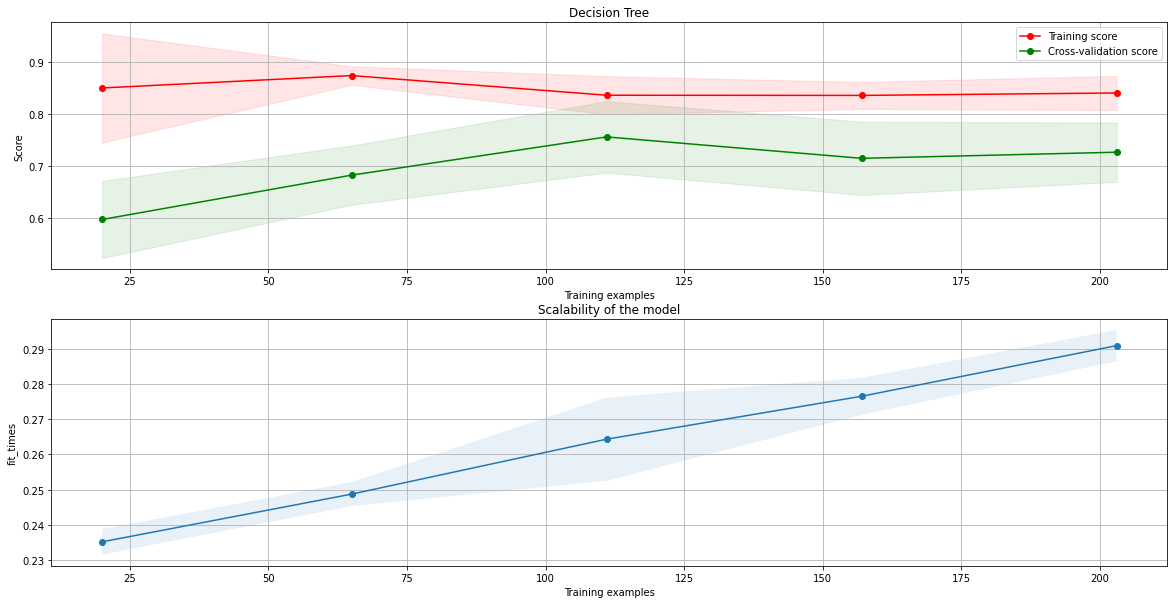

In [33]:
# Building learning curve of model
plot_learning_curve(decision_tree_CV, "Decision Tree", train, train_target, cv=cv_train)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 50}
train_target =  [0 1 1 0 0]
ytrain =  [1 1 1 0 0]
valid_target = [1 1 0 1 1]
yvalid = [0 0 0 0 1]
acc of acc for train = 0.82
acc of acc for valid = 0.76
acc of rmse for train = 0.42
acc of rmse for valid = 0.49
acc of re for train = 40.68
acc of re for valid = 53.66


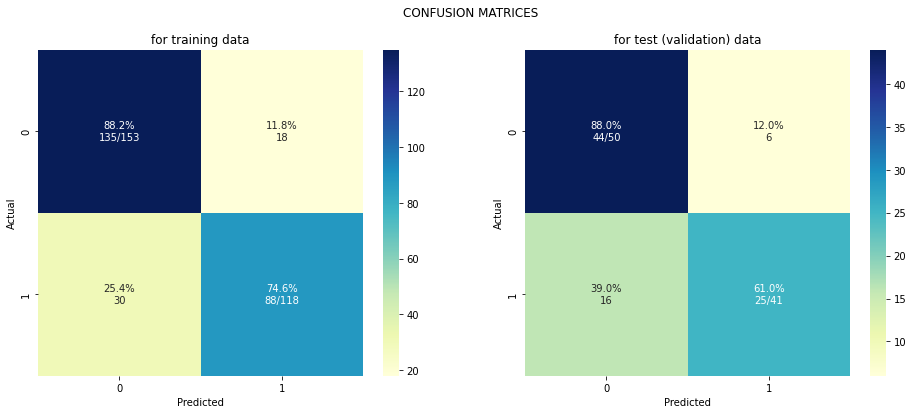

CPU times: user 47.1 s, sys: 407 ms, total: 47.5 s
Wall time: 47.2 s


In [34]:
%%time
# Random Forest
# Parameters of model (param_grid) taken from the notebook https://www.kaggle.com/morenovanton/titanic-random-forest

random_forest = RandomForestClassifier()
param_grid = {'n_estimators': [50, 60, 80, 100], 'min_samples_leaf': [12, 13, 14, 15, 16, 17], 
              'max_features': ['auto'], 'max_depth': [3, 4, 5, 6], 'criterion': ['gini'], 'bootstrap': [False]}
random_forest_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, 
                             cv=cv_train, verbose=False)
random_forest_CV.fit(train, train_target)
print(random_forest_CV.best_params_)
acc_all = acc_metrics_calc(1, acc_all, random_forest_CV, train, valid, train_target, valid_target)

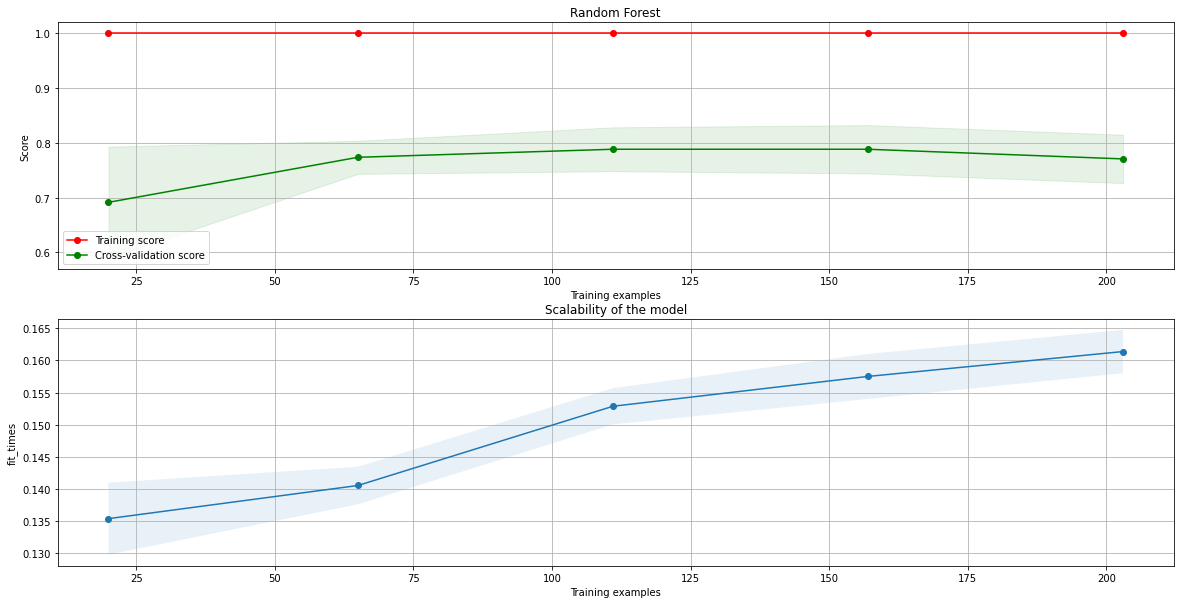

In [35]:
# Building learning curve of model
plot_learning_curve(random_forest, "Random Forest", train, train_target, cv=cv_train)

Best score: 0.768
Best parameters set: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 60}
train_target =  [0 1 1 0 0]
ytrain =  [1 1 1 0 0]
valid_target = [1 1 0 1 1]
yvalid = [0 0 0 0 1]
acc of acc for train = 0.88
acc of acc for valid = 0.74
acc of rmse for train = 0.34
acc of rmse for valid = 0.51
acc of re for train = 27.12
acc of re for valid = 58.54


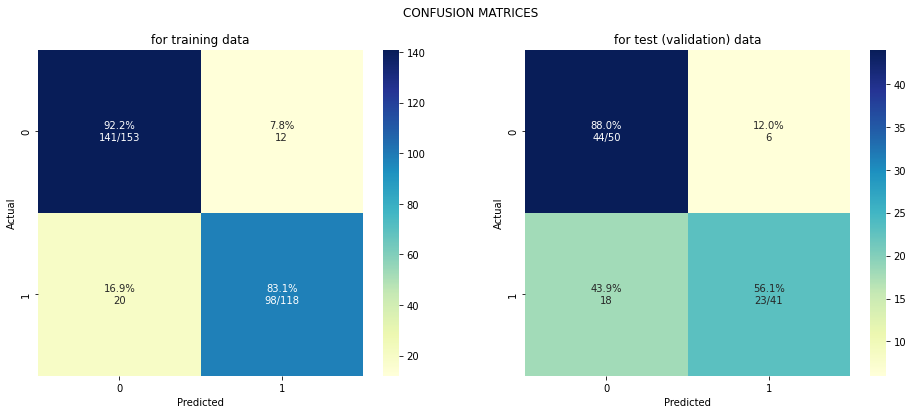

CPU times: user 4min 37s, sys: 2.8 s, total: 4min 39s
Wall time: 1min 11s


In [36]:
%%time
# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(objective='reg:squarederror') 
parameters = {'n_estimators': [30, 40, 50, 60, 75, 100], 
              'learning_rate': [0.01, 0.03, 0.05, 0.1],
              'max_depth': [3, 4, 5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=cv_train).fit(train, train_target)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_all = acc_metrics_calc(2, acc_all, xgb_reg, train, valid, train_target, valid_target)

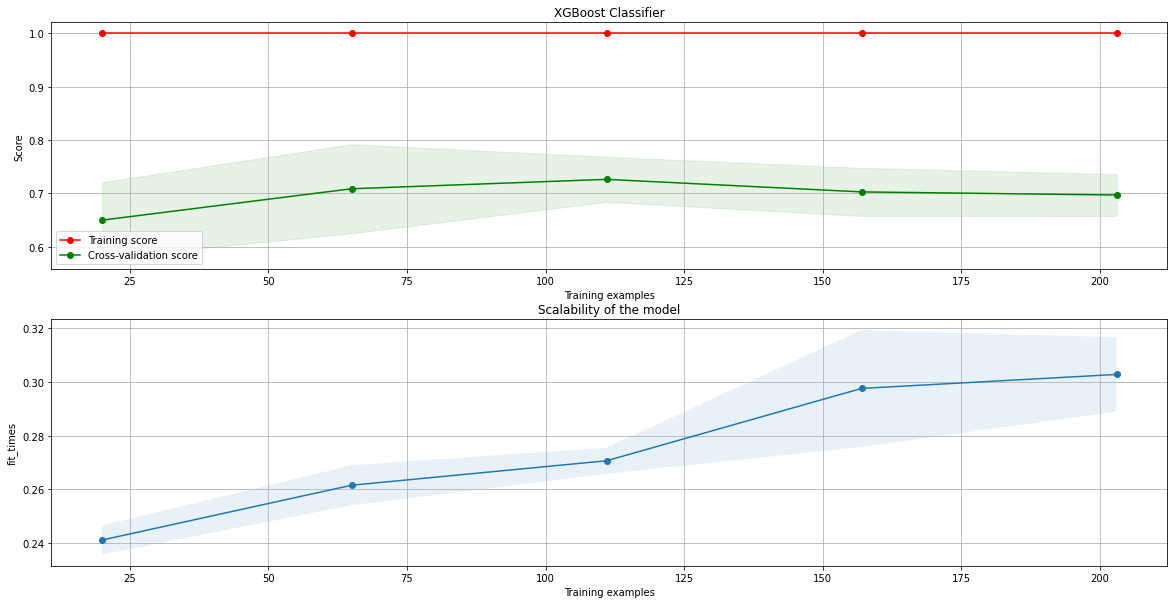

In [37]:
# Building learning curve of model
plot_learning_curve(xgb_clf, "XGBoost Classifier", train, train_target, cv=cv_train)

{'learning_rate': 0.2}
train_target =  [0 1 1 0 0]
ytrain =  [0 1 1 0 0]
valid_target = [1 1 0 1 1]
yvalid = [0 0 0 0 1]
acc of acc for train = 0.86
acc of acc for valid = 0.74
acc of rmse for train = 0.38
acc of rmse for valid = 0.51
acc of re for train = 33.05
acc of re for valid = 58.54


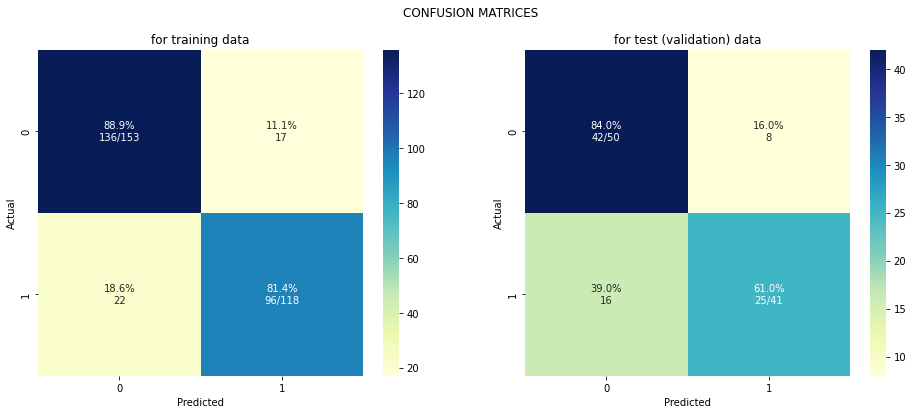

In [43]:
# AdaBoost Classifier

Ada_Boost = AdaBoostClassifier()
Ada_Boost_CV = GridSearchCV(estimator=Ada_Boost, param_grid={'learning_rate' : [0.09, 0.1, 0.2]}, cv=cv_train, verbose=False)
Ada_Boost_CV.fit(train, train_target)
print(Ada_Boost_CV.best_params_)
acc_all = acc_metrics_calc(5, acc_all, Ada_Boost_CV, train, valid, train_target, valid_target)

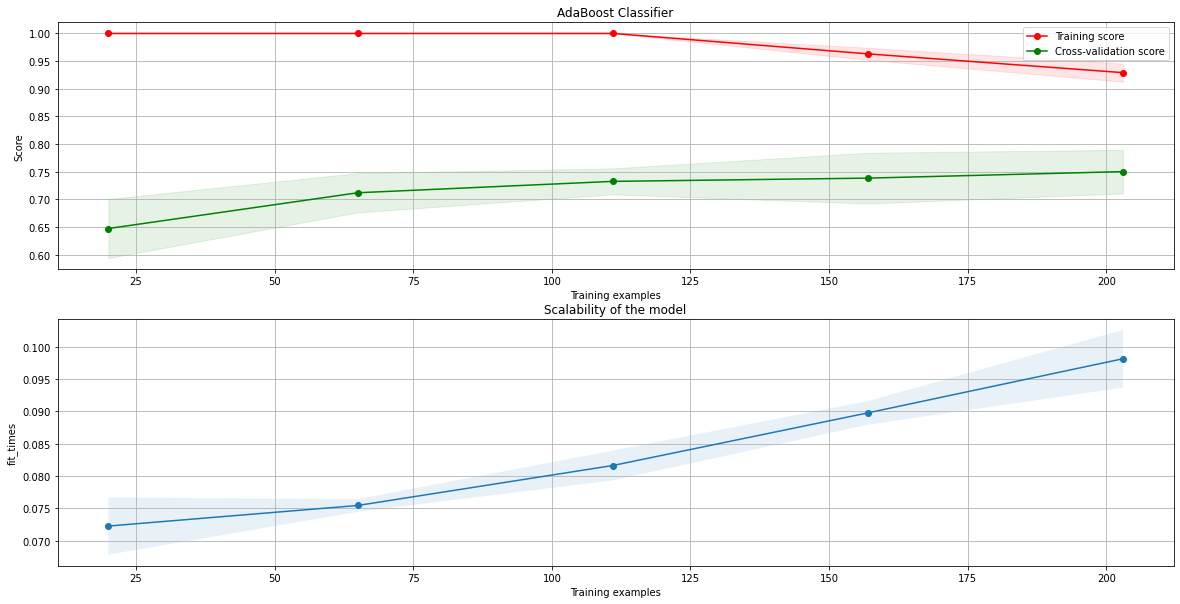

In [44]:
# Building learning curve of model
plot_learning_curve(Ada_Boost, "AdaBoost Classifier", train, train_target, cv=cv_train)

We can now rank our evaluation of all the models to choose the best one for our problem.

In [45]:
models = pd.DataFrame({
    'Model': ['Decision Tree Classifier', 
              'Random Forest Classifier',  
              'XGB Classifier', 
              'AdaBoost Classifier', 
              ]})

In [46]:
for x in metrics_now:
    xs = metrics_all[x]
    models[xs + '_train'] = acc_all[(x-1)*2]
    models[xs + '_valid'] = acc_all[(x-1)*2+1]
    if xs == "acc":
        models[xs + '_diff'] = models[xs + '_train'] - models[xs + '_valid']
#models

In [47]:
print('Prediction accuracy for models')
ms = metrics_all[metrics_now[0]] # the first from metrics
models[['Model', ms + '_train', ms + '_valid', 'acc_diff']].sort_values(by=[(ms + '_valid'), (ms + '_train')], ascending=False)

Prediction accuracy for models


Model  acc_train  acc_valid  acc_diff
3           LGBM Classifier       0.85       0.77      0.08
1  Random Forest Classifier       0.82       0.76      0.06
2            XGB Classifier       0.88       0.74      0.14
5       AdaBoost Classifier       0.86       0.74      0.12
0  Decision Tree Classifier       0.82       0.70      0.12
4     ExtraTrees Classifier       0.77       0.69      0.08

In [48]:
pd.options.display.float_format = '{:,.2f}'.format

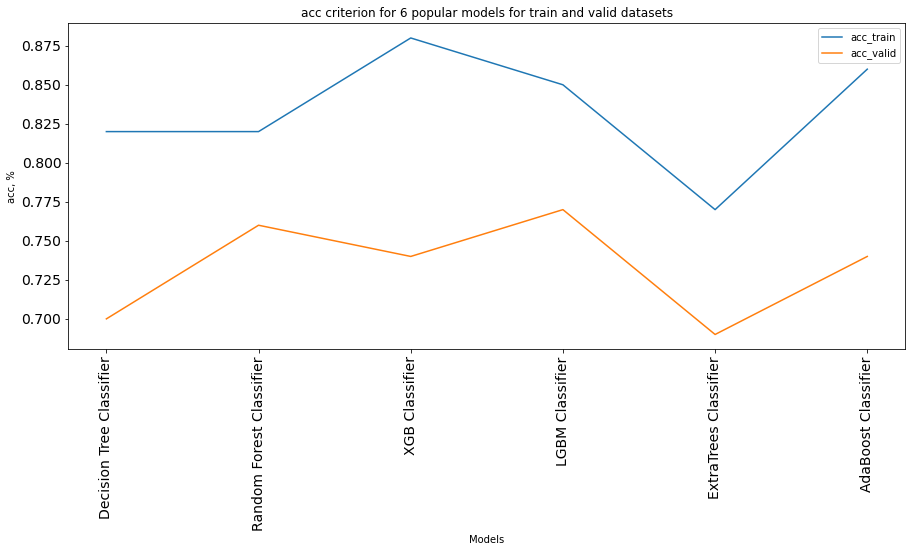

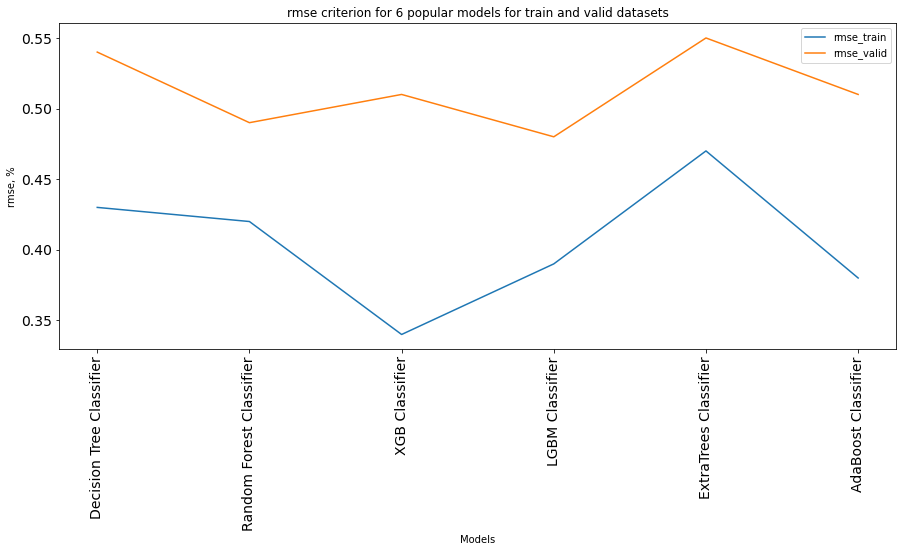

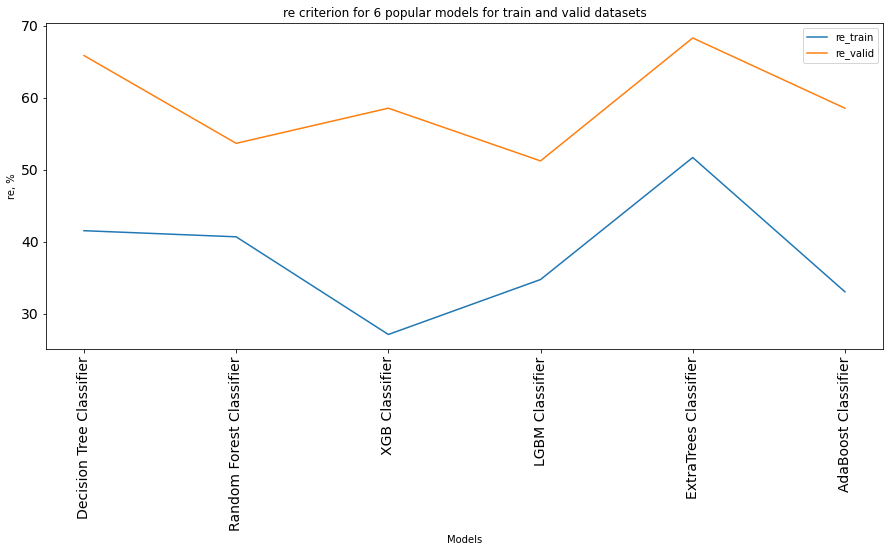

In [49]:
for x in metrics_now:   
    # Plot
    xs = metrics_all[x]
    xs_train = metrics_all[x] + '_train'
    xs_test = metrics_all[x] + '_valid'
    plt.figure(figsize=[15,6])
    xx = models['Model']
    plt.tick_params(labelsize=14)
    plt.plot(xx, models[xs_train], label = xs_train)
    plt.plot(xx, models[xs_test], label = xs_test)
    plt.legend()
    plt.title(str(xs) + ' criterion for ' + str(num_models) + ' popular models for train and valid datasets')
    plt.xlabel('Models')
    plt.ylabel(xs + ', %')
    plt.xticks(xx, rotation='vertical')
    plt.show()

In [50]:
# Choose the number of metric by which the best models will be determined =>  {1: 'accuracy_score', 2 : 'relative_error', 3 : 'rmse'}
metrics_main = 1
xs = metrics_all[metrics_main]
xs_train = metrics_all[metrics_main] + '_train'
xs_test = metrics_all[metrics_main] + '_valid'
print('The best models by the',xs,'criterion:')
direct_sort = False if (metrics_main==1) else True
models.sort_values(by=[xs_test, xs_train], ascending=direct_sort)

The best models by the acc criterion:


Model  acc_train  acc_valid  acc_diff  rmse_train  \
3           LGBM Classifier       0.85       0.77      0.08        0.39   
1  Random Forest Classifier       0.82       0.76      0.06        0.42   
2            XGB Classifier       0.88       0.74      0.14        0.34   
5       AdaBoost Classifier       0.86       0.74      0.12        0.38   
0  Decision Tree Classifier       0.82       0.70      0.12        0.43   
4     ExtraTrees Classifier       0.77       0.69      0.08        0.47   

   rmse_valid  re_train  re_valid  
3        0.48     34.75     51.22  
1        0.49     40.68     53.66  
2        0.51     27.12     58.54  
5        0.51     33.05     58.54  
0        0.54     41.53     65.85  
4        0.55     51.69     68.29

In [51]:
# Selection the best models
models_best = models[(models.acc_diff < 0.1) & (models.acc_valid > 0.7)]
if len(models_best)>0:
    print('The best models:')
    display(models_best[['Model', 'acc_train', 'acc_valid']].sort_values(by=['acc_valid'], ascending=False))
    # Selection the best models from the best
    models_best_best = models_best[(models_best.acc_valid > 0.9)]
    if len(models_best_best)>0:
        print('Optimal model:')
        display(models_best_best[['Model', 'acc_train', 'acc_valid']].sort_values(by=['acc_valid'], ascending=False))
    else: print('But no model provides good accuracy at least above 0.9')
else:
    print('There are no good models - either they have not learned enough, or they have overfit!')

The best models:


Model  acc_train  acc_valid
3           LGBM Classifier       0.85       0.77
1  Random Forest Classifier       0.82       0.76

But no model provides good accuracy at least above 0.9
